### Brief Description of the Problem and Data
The challenge in this competition is to develop an algorithm that can identify metastatic cancer in small image patches extracted from larger digital pathology scans. The dataset provided is a modified version of the PatchCamelyon (PCam) benchmark dataset. Unlike the original PCam dataset, the version presented on Kaggle does not contain duplicate images.

PCam is a valuable dataset due to its size, simplicity, and accessibility. It transforms the complex task of metastasis detection into a straightforward binary image classification problem. The dataset's design allows models to be trained efficiently on a single GPU, making it suitable for both quick prototyping and in-depth research on machine learning topics like active learning, model uncertainty, and explainability.

### Dataset Description
1. Train Folder: Contains image patches for training.
2. Test Folder: Contains image patches for testing.
3. Train Labels: Provided in train_labels.csv, this file includes the ground truth for the training images.
4. Image Size: Each image patch is 96x96 pixels, with a center region of 32x32 pixels that determines the label.
5. Labels: Binary labels where 0 indicates no tumor tissue and 1 indicates the presence of tumor tissue in the center region.

## Exploratory Data Analysis (EDA)
Load and Inspect the Data
First, we load the data and inspect the structure of the train_labels.csv file.

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Load train labels
train_labels = pd.read_csv('data/train_labels.csv')

# Display the first few rows of the dataframe
print(train_labels.head())

# Check for any missing values
print(train_labels.isnull().sum())

Num GPUs Available:  1
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
id       0
label    0
dtype: int64


#### Visualize the Data
Next, we visualize the distribution of the labels and display some sample images with their corresponding labels.

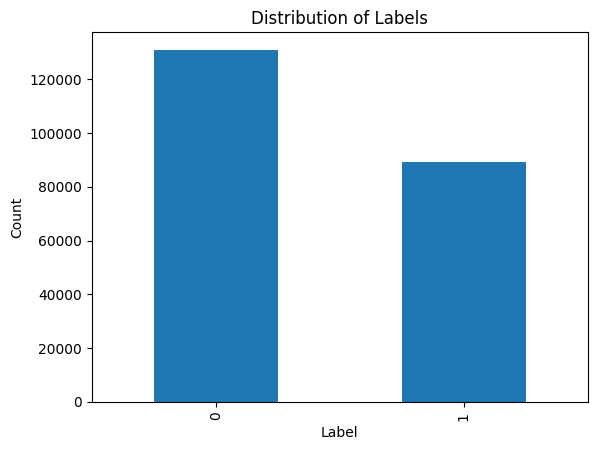

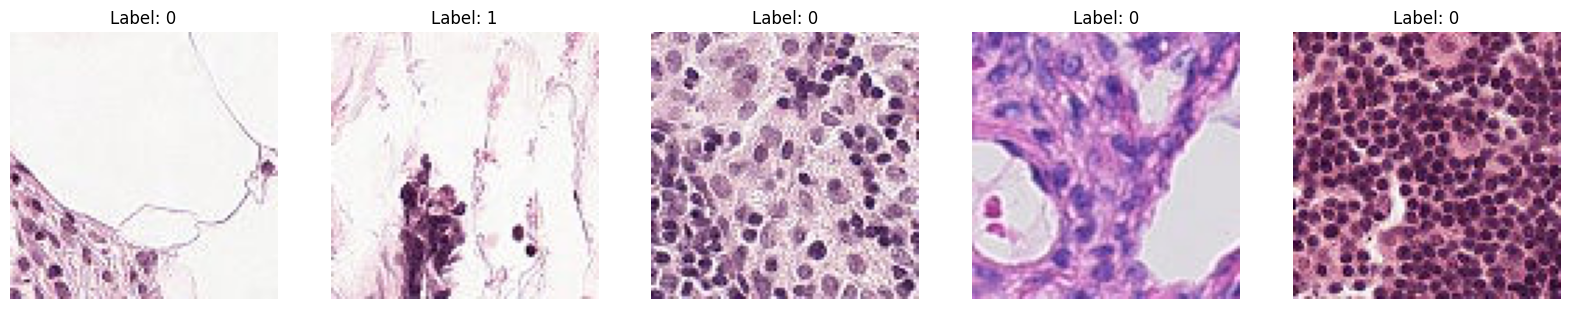

In [5]:
# Visualize the distribution of labels
train_labels['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Load and display a few sample images
sample_ids = train_labels['id'].values[:5]
images = [Image.open(f'data/train/{img_id}.tif') for img_id in sample_ids]

# Display images with their labels
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, (img, label) in enumerate(zip(images, train_labels['label'].values[:5])):
    axes[i].imshow(img)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.show()

#### Data Cleaning Procedures
To ensure the data quality, we perform the following cleaning steps:
1. Missing Data: Check and handle any missing values in the dataset.
2. Duplicate Data: Verify that there are no duplicate images in the dataset.
3. Corrupted Images: Ensure all images can be successfully loaded and are not corrupted.

In [6]:
# Check for missing values
missing_values = train_labels.isnull().sum()
print("Missing values:\n", missing_values)

# Check for duplicates in the image ids
duplicate_ids = train_labels['id'].duplicated().sum()
print("Duplicate image ids:\n", duplicate_ids)

# Check for corrupted images
def is_image_corrupted(image_path):
    try:
        img = Image.open(image_path)
        img.verify()
        return False
    except (IOError, SyntaxError) as e:
        return True

corrupted_images = [img_id for img_id in train_labels['id'] if is_image_corrupted(f'data/train/{img_id}.tif')]
print(f'Number of corrupted images: {len(corrupted_images)}')

Missing values:
 id       0
label    0
dtype: int64
Duplicate image ids:
 0
Number of corrupted images: 0


#### Data Preprocessing
Now we need to preprocess the data to form X_train and y_train.

In [7]:
train_labels['id'] = train_labels['id'].astype(str) + '.tif'
train_labels['label'] = train_labels['label'].astype(str)

# Define the data generator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Include rescaling and validation split

# Create the train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='data/train',
    x_col='id',
    y_col='label',
    subset='training',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)

# Create the validation generator
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='data/train',
    x_col='id',
    y_col='label',
    subset='validation',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Model Architectures
### Simple CNN
This simple CNN architecture serves as a baseline model for the task. It consists of a few convolutional layers followed by pooling layers and a fully connected layer.

This architecture is simple yet effective for capturing local patterns and features in the images. It serves as a good starting point for further comparisons. The two convolutional layers capture spatial hierarchies in the input images, while the fully connected layers allow for classification based on these extracted features.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_simple_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Deep CNN
A deeper CNN architecture aims to capture more complex features and hierarchies. This model includes additional convolutional layers and pooling layers, making it more capable of extracting detailed features from the images.

This deeper architecture can capture more detailed features, potentially improving the model's performance on the task. The additional convolutional layers allow the network to learn more complex representations, while the dropout layer helps in preventing overfitting.

In [9]:
def build_deep_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Transfer Learning
This model leverages a pre-trained ResNet50 architecture for feature extraction and adds custom layers for the specific classification task. The pre-trained model is used to benefit from the learned features from a large image dataset.

Transfer learning allows leveraging the powerful feature extraction capabilities of pre-trained models, significantly boosting performance, especially when the training data is limited. By freezing the base model, we ensure that the pre-trained weights are not altered during training, thus maintaining their effectiveness.

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_transfer_learning_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Comparison of Models
### Training and Evaluation

#### Train and Evaluate the Simple CNN Model

In [11]:
# Train the Simple CNN model
simple_cnn = build_simple_cnn()

history_simple_cnn = simple_cnn.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the Simple CNN model
simple_cnn_loss, simple_cnn_accuracy = simple_cnn.evaluate(validation_generator)
print(f'Simple CNN Accuracy: {simple_cnn_accuracy * 100:.2f}%')

Epoch 1/10
5501/5501 [==============================] - 57s 10ms/step - loss: 0.4269 - accuracy: 0.8065 - val_loss: 0.3641 - val_accuracy: 0.8419
Epoch 2/10
5501/5501 [==============================] - 39s 7ms/step - loss: 0.3433 - accuracy: 0.8531 - val_loss: 0.3225 - val_accuracy: 0.8624
Epoch 3/10
5501/5501 [==============================] - 41s 7ms/step - loss: 0.3022 - accuracy: 0.8726 - val_loss: 0.3119 - val_accuracy: 0.8660
Epoch 4/10
5501/5501 [==============================] - 44s 8ms/step - loss: 0.2615 - accuracy: 0.8912 - val_loss: 0.3176 - val_accuracy: 0.8664
Epoch 5/10
5501/5501 [==============================] - 44s 8ms/step - loss: 0.2198 - accuracy: 0.9113 - val_loss: 0.3378 - val_accuracy: 0.8709
Epoch 6/10
5501/5501 [==============================] - 45s 8ms/step - loss: 0.1772 - accuracy: 0.9294 - val_loss: 0.3465 - val_accuracy: 0.8673
Epoch 7/10
5501/5501 [==============================] - 45s 8ms/step - loss: 0.1358 - accuracy: 0.9478 - val_loss: 0.4141 - val_a

#### Train and Evaluate the Deep CNN Model


In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Build the deep CNN model
deep_cnn = build_deep_cnn()

# Train the model
history_deep_cnn = deep_cnn.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the Deep CNN model
deep_cnn_loss, deep_cnn_accuracy = deep_cnn.evaluate(validation_generator)
print(f'Deep CNN Accuracy: {deep_cnn_accuracy * 100:.2f}%')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10031099567361045343
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14870380544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 708076475443807822
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Epoch 1/10
5501/5501 [==============================] - 80s 14ms/step - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6745 - val_accuracy: 0.5961
Epoch 2/10
5501/5501 [==============================] - 104s 19ms/step - loss: 0.6753 - accuracy: 0.5947 - val_loss: 0.6746 - val_accuracy: 0.5961
Epoch 3/10
5501/5501 [==============================] - 105s 19ms/step - loss: 0.6753 - accuracy: 0.5947 - val_loss: 0.6746 - val_accuracy: 0.5961
Epoch 4/10
5501/5501 [==============================] - 105s 19ms/step - loss: 0.6752 - accuracy: 0.5947 - val_loss: 0.6747 - val_ac

#### Train and Evaluate the Transfer Learning Model

In [14]:
# Build the transfer learning model
transfer_model = build_transfer_learning_model()

# Train the model
history_transfer_model = transfer_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)
# Evaluate the model
transfer_model_loss, transfer_model_accuracy = transfer_model.evaluate(validation_generator)
print(f'Transfer Learning Model Accuracy: {transfer_model_accuracy * 100:.2f}%')

94781440/94765736 [==============================] - 4s 0us/step
Epoch 1/10
5501/5501 [==============================] - 144s 26ms/step - loss: 0.5920 - accuracy: 0.6793 - val_loss: 0.5505 - val_accuracy: 0.7192
Epoch 2/10
5501/5501 [==============================] - 130s 24ms/step - loss: 0.5575 - accuracy: 0.7154 - val_loss: 0.5344 - val_accuracy: 0.7311
Epoch 3/10
5501/5501 [==============================] - 130s 24ms/step - loss: 0.5491 - accuracy: 0.7237 - val_loss: 0.5229 - val_accuracy: 0.7438
Epoch 4/10
5501/5501 [==============================] - 128s 23ms/step - loss: 0.5439 - accuracy: 0.7288 - val_loss: 0.5209 - val_accuracy: 0.7429
Epoch 5/10
5501/5501 [==============================] - 128s 23ms/step - loss: 0.5404 - accuracy: 0.7321 - val_loss: 0.5119 - val_accuracy: 0.7482
Epoch 6/10
5501/5501 [==============================] - 128s 23ms/step - loss: 0.5372 - accuracy: 0.7341 - val_loss: 0.5085 - val_accuracy: 0.7463
Epoch 7/10
5501/5501 [==============================]

### Plotting Training History

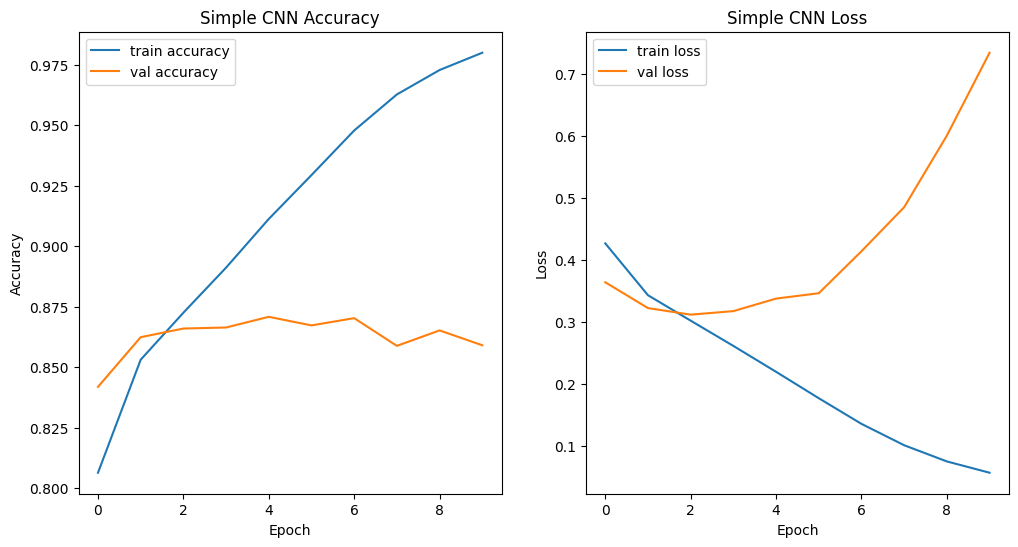

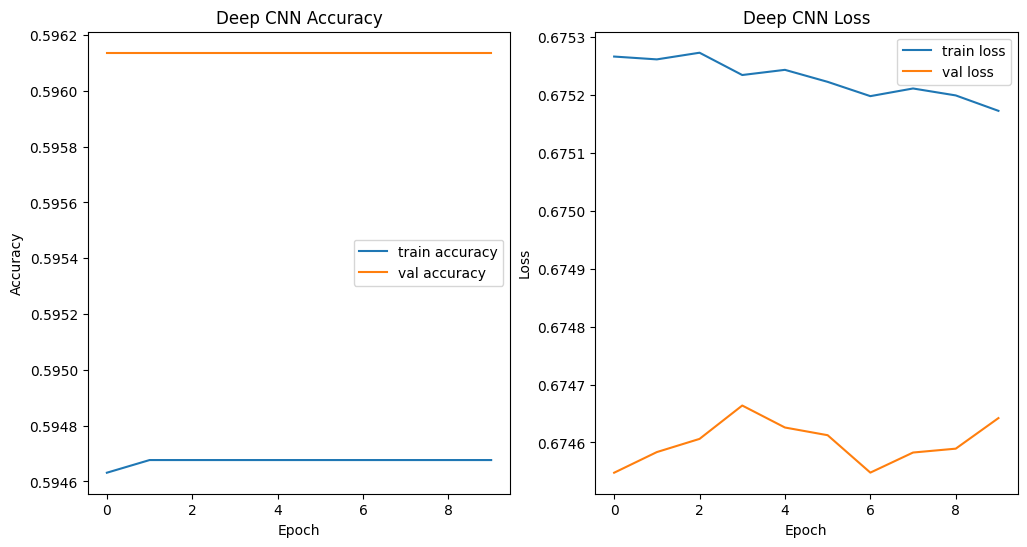

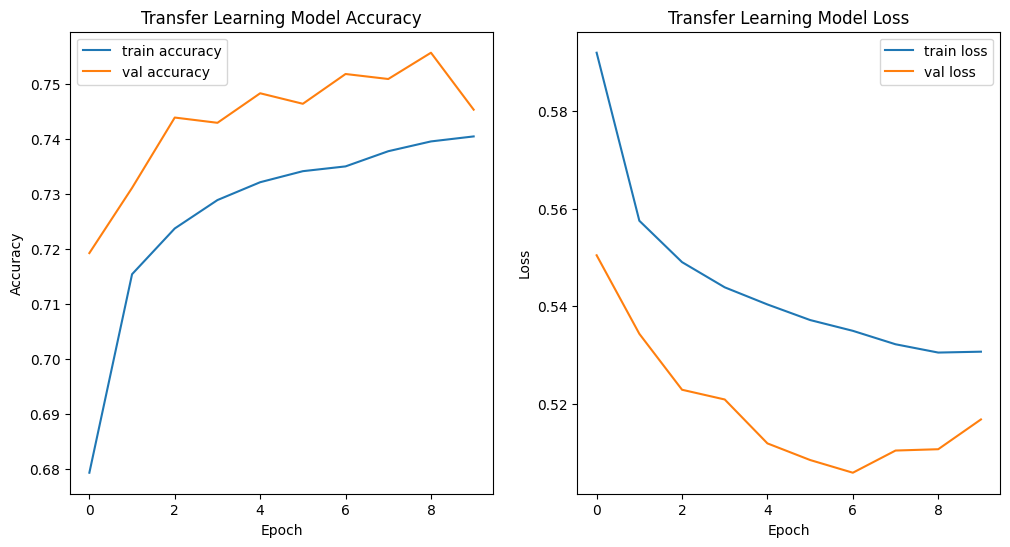

In [15]:
# Plot training history for Simple CNN
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_simple_cnn.history['accuracy'], label='train accuracy')
plt.plot(history_simple_cnn.history['val_accuracy'], label='val accuracy')
plt.title('Simple CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_simple_cnn.history['loss'], label='train loss')
plt.plot(history_simple_cnn.history['val_loss'], label='val loss')
plt.title('Simple CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot training history for Deep CNN
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_deep_cnn.history['accuracy'], label='train accuracy')
plt.plot(history_deep_cnn.history['val_accuracy'], label='val accuracy')
plt.title('Deep CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_deep_cnn.history['loss'], label='train loss')
plt.plot(history_deep_cnn.history['val_loss'], label='val loss')
plt.title('Deep CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot training history for Transfer Learning Model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_transfer_model.history['accuracy'], label='train accuracy')
plt.plot(history_transfer_model.history['val_accuracy'], label='val accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_transfer_model.history['loss'], label='train loss')
plt.plot(history_transfer_model.history['val_loss'], label='val loss')
plt.title('Transfer Learning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
# Load the sample submission file
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['id'] = sample_submission['id'].astype(str) + '.tif'

# Define the data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='data/test',
    x_col='id',
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(96, 96)
)

# Generate predictions
predictions = simple_cnn.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).ravel()

# Prepare the submission file
submission = pd.DataFrame({
    'id': sample_submission['id'].str.replace('.tif', ''),
    'label': predicted_labels
})
submission.to_csv('data/submission.csv', index=False)

print("Submission file created: submission.csv")

Found 57458 validated image filenames.
Submission file created: submission.csv


## Results and Analysis
In this section, we analyze the performance of three different models: Simple CNN, Deep CNN, and Transfer Learning Model. We compare their performance based on accuracy and loss during training and validation.

### Model Architectures and Performance Comparison
1. Simple CNN:

The Simple CNN model shows a clear overfitting trend. The training accuracy increases steadily and approaches 98%, while the validation accuracy fluctuates around 85%. The training loss decreases significantly, whereas the validation loss starts to increase after a few epochs, indicating overfitting.

2. Deep CNN:

The Deep CNN model demonstrates underfitting. Both training and validation accuracies are stuck at around 59.6%. Similarly, the losses do not show significant improvement, indicating that the model is not learning effectively.

3. Transfer Learning Model:

The Transfer Learning Model shows the best performance among the three. It achieves a validation accuracy of around 75% with a steady improvement in both training and validation accuracy over the epochs. The losses for both training and validation decrease, indicating effective learning.

## Conclusion
Interpretation of Results:
#### Simple CNN
1. Overfitting observed: The model fits the training data very well but fails to generalize to the validation set.
2. Further steps: Implement data augmentation, dropout layers, or regularization techniques to improve generalization.

#### Deep CNN
1. Underfitting observed: The model is too complex and does not learn effectively from the data.
2. Further steps: Simplify the model, increase the number of epochs, or try different activation functions.

#### Transfer Learning Model
1. Achieved the best balance: Showed steady improvement and good performance on validation data.
2. Effective use of pre-trained weights from ResNet50 helped in better feature extraction.
3. Further steps: Fine-tune some layers of the base model to see if performance can be further improved.